# Flight Price Forecast – Kayak

## Table of Contents
- [Introduction](#introduction)
- [Imports](#imports)
- [Data Preprocessing](#data-preprocessing)
- [Linear Regression](#linear-regression)
- [Decision Tree](#decision-tree)
- [Gaussian Process Regression](#gaussian-process-regression)
- [Random Forest](#random-forest)
- [GridSearchCV](#gridsearchcv)
- [KNN Regressor](#knn-regressor)
- [MLP Regressor](#mlp-regressor)
- [XG Boost Regressor](#xg-boost-regressor)
- [Hist Gradient Boosting](#hist-gradient-boosting)
- [Best Performance with Best Parameters](#best-performance-with-best-parameters)
- [Feature Importance](#feature-importance)
- [Conclusions](#conclusions)

---

## Introduction

The provided Python code develops a machine learning pipeline for predicting flight prices, starting with data preprocessing such as cleaning and converting price data, date extraction, duration conversion, and numeric encoding of categorical features like flight stops.  
The pipeline evaluates multiple regression methods, including Linear Regression, Decision Trees, Gaussian Process, Random Forests (with GridSearchCV optimization), K-Nearest Neighbors, Multi-layer Perceptron, XGBoost, and HistGradientBoostingRegressor, comparing their performance using metrics like R², RMSE, MSE, and MAE.

**Our Top models:** *"Random Forest"*, *"XGBoost"*, and *"HistGradientBoosting"* regressors demonstrated the strongest predictive performances, while significantly outperforming basic linear models.  
Using visualization tools such as residual plots, permutation importance, and predicted-versus-actual graphs provided insights into model accuracy and feature relevance.


# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.inspection import permutation_importance

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Data Preprocessing

In [5]:

df = pd.read_csv('kayak_cleaned.csv')


print(df.head())
print(df.info())

   departure_hour departure_airport  flight_length  landing_hour  \
0       13.833333               LGW             75     16.083333   
1       18.166667               LGW             80     20.500000   
2       16.166667               LGW             75     18.416667   
3       16.516667               LON            138     19.816667   
4       12.750000               LGW             80     15.083333   

  landing_airport to_dest_company  return_departure_hour  \
0             CDG         easyJet              21.166667   
1             CDG         easyJet              10.250000   
2             ORY         Vueling              16.583333   
3             PAR        Eurostar               7.150000   
4             ORY         Vueling              16.000000   

  return_departure_airport  return_flight_length  return_landing_hour  ...  \
0                      CDG                    65            21.250000  ...   
1                      CDG                    80            10.583333  ...

In [6]:

df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace('"', '', regex=False)
df['price'] = df['price'].str.replace("'", '', regex=False)
df['price'] = df['price'].str.replace(",", '', regex=False)
df['price'] = df['price'].str.strip()

# 2. המרה ל־float
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 3. הסרה של שורות בלי מחיר
df = df.dropna(subset=['price'])

# 4. בדיקה
print(df['price'].dtype)  # אמור להיות float64
print(df.shape)           # כמה שורות נשארו
        # כמה שורות נשארו


float64
(85764, 27)


In [7]:
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
df['departure_date'] = pd.to_datetime(df['departure_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

df['dep_weekday'] = df['departure_date'].dt.weekday
df['dep_day'] = df['departure_date'].dt.day
df['dep_month'] = df['departure_date'].dt.month
df['is_weekend'] = df['dep_weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [8]:
df['ttt'] = (df['departure_date'] - df['snapshot_date']).dt.days

In [9]:
df['Stops'] = df['layover'].astype(int)

In [12]:
features = ['Stops', 'flight_length', 'layover_time',
            'dep_weekday', 'dep_day', 'dep_month']

df.dropna(subset=features, inplace=True)


In [13]:
df.to_csv('kayak_final.csv', index=False)


In [15]:
pd.read_csv('kayak_final.csv').head()



,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,layover_time,return_layover_time,day_of_week,route,time_category,dep_weekday,dep_day,dep_month,is_weekend,Stops
0,13.833333,LGW,75,16.083333,CDG,easyJet,21.166667,CDG,65,21.250000,...,0,0,Sunday,LONDON_PARIS,Afternoon_12_18,6,2,3,1,0
1,18.166667,LGW,80,20.500000,CDG,easyJet,10.250000,CDG,80,10.583333,...,0,0,Thursday,LONDON_PARIS,Evening_18_24,3,20,3,0,0
2,16.166667,LGW,75,18.416667,ORY,Vueling,16.583333,CDG,65,16.666667,...,0,0,Tuesday,LONDON_PARIS,Afternoon_12_18,1,4,3,0,0
3,16.516667,LON,138,19.816667,PAR,Eurostar,7.150000,PAR,141,8.500000,...,53,51,Tuesday,LONDON_PARIS,Afternoon_12_18,1,11,3,0,1
4,12.750000,LGW,80,15.083333,ORY,Vueling,16.000000,CDG,75,16.250000,...,0,0,Saturday,LONDON_PARIS,Afternoon_12_18,5,1,3,1,0


# Model Training

In [17]:

features = ['Stops', 'flight_length', 'layover_time',
            'dep_weekday', 'dep_day', 'dep_month']


train_df = df[df['ttt'] <= 25].copy()
test_df = df[df['ttt'] > 25].copy()


X_train = train_df[features]
y_train = train_df['price']

X_test = test_df[features]
y_test = test_df['price']


In [18]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (78743, 6)
Test shape: (7021, 6)


In [19]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # אימון
    model.fit(X_train, y_train)
    
    # ניבוי
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # חישוב מדדים
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    
    print(f"=== {model_name} ===")
    print(f"Train -> R2: {r2_train:.3f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Test  -> R2: {r2_test:.3f},  MSE: {mse_test:.2f},  RMSE: {rmse_test:.2f},  MAE: {mae_test:.2f}")
    
    # Residual Plot
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6,4))
    palette = sns.color_palette("viridis", n_colors=10) 
    color = palette[4]
    sns.scatterplot(x=y_pred_test, y=residuals, color=color, alpha=0.6, edgecolor='black')
    plt.axhline(y=0, color='r', linestyle='dashed', linewidth=2)
    plt.title(f"{model_name} - Residual Plot (Test)")
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual (y_test - y_pred)")
    plt.show()
    
    return model

# Linear Regression

=== Linear Regression ===
Train -> R2: 0.151, MSE: 3131.62, RMSE: 55.96, MAE: 45.28
Test  -> R2: -0.215,  MSE: 2795.91,  RMSE: 52.88,  MAE: 41.88


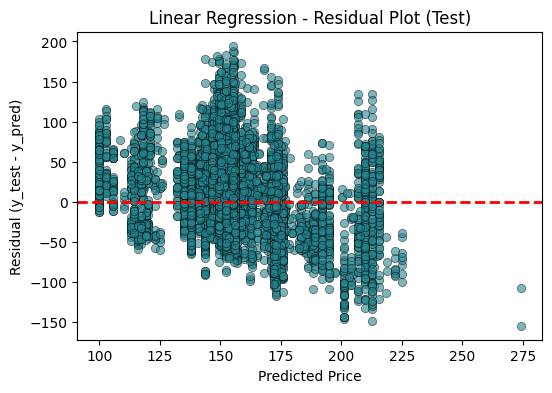

=== Linear Regression (StandardScaler) ===
Train -> R2: 0.151, MSE: 3131.62, RMSE: 55.96, MAE: 45.28
Test  -> R2: -0.215,  MSE: 2795.91,  RMSE: 52.88,  MAE: 41.88


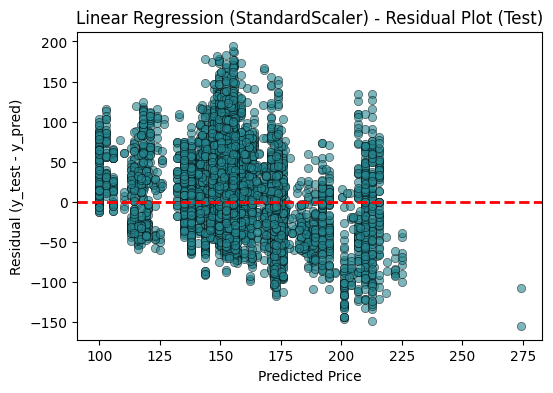

=== Linear Regression (MinMaxScaler) ===
Train -> R2: 0.151, MSE: 3131.62, RMSE: 55.96, MAE: 45.28
Test  -> R2: -0.215,  MSE: 2795.91,  RMSE: 52.88,  MAE: 41.88


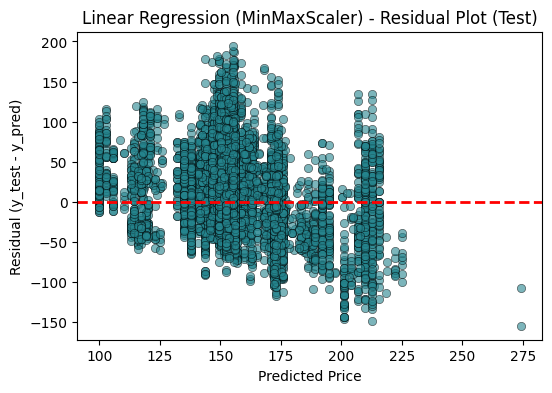

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. מודל לינארי רגיל
linreg = LinearRegression()
linreg = train_and_evaluate_model(linreg, X_train, y_train, X_test, y_test, "Linear Regression")

# 2. מודל לינארי עם StandardScaler
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

linreg_std = LinearRegression()
linreg_std = train_and_evaluate_model(linreg_std, X_train_std, y_train, X_test_std, y_test, "Linear Regression (StandardScaler)")

# 3. מודל לינארי עם MinMaxScaler
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

linreg_mm = LinearRegression()
linreg_mm = train_and_evaluate_model(linreg_mm, X_train_mm, y_train, X_test_mm, y_test, "Linear Regression (MinMaxScaler)")


## Conclusions – Linear Regression on Kayak Data

Despite testing three versions of linear regression (raw, StandardScaler, MinMaxScaler), results were consistently poor.

### Key Results:
- **R² (Train):** 0.151  
- **R² (Test):** –0.215 → Indicates the model performs worse than predicting the mean.
- **RMSE (Test):** 52.88  
- **MAE (Test):** 41.88

### Insights:
- The residuals display clear patterns, violating the assumption of randomness.
- All models underfit the data and fail to capture key relationships.

### Conclusion:
Linear regression is not suitable for this dataset.  
The low explanatory power and structured residuals indicate the need for non-linear models such as Random Forest or Gradient Boosting.



# Decision-Tree

=== Decision Tree (max_depth=3) ===
Train -> R2: 0.330, MSE: 2470.43, RMSE: 49.70, MAE: 39.70
Test  -> R2: -0.119,  MSE: 2574.38,  RMSE: 50.74,  MAE: 40.54


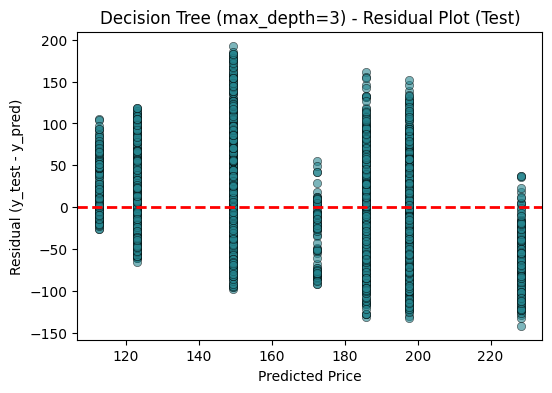

=== Decision Tree (max_depth=5) ===
Train -> R2: 0.381, MSE: 2282.74, RMSE: 47.78, MAE: 38.13
Test  -> R2: -0.122,  MSE: 2581.08,  RMSE: 50.80,  MAE: 40.41


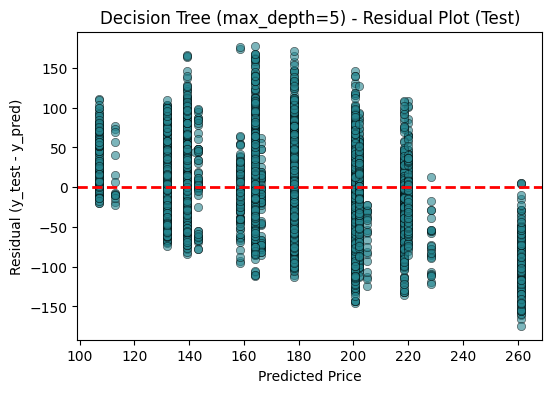

=== Decision Tree (max_depth=7) ===
Train -> R2: 0.429, MSE: 2107.01, RMSE: 45.90, MAE: 36.61
Test  -> R2: -0.159,  MSE: 2666.84,  RMSE: 51.64,  MAE: 40.28


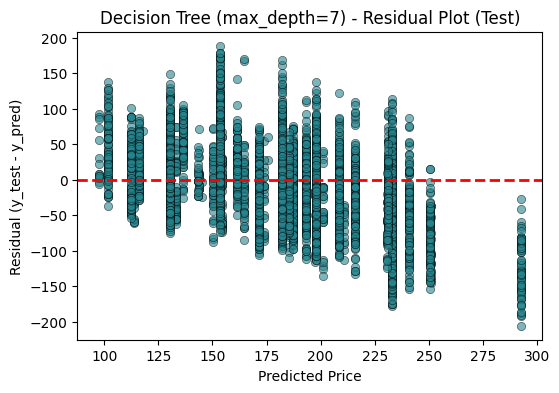

In [21]:
from sklearn.tree import DecisionTreeRegressor

for max_depth in [3, 5, 7]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model_name = f"Decision Tree (max_depth={max_depth})"
    dt = train_and_evaluate_model(dt, X_train, y_train, X_test, y_test, model_name)


### Decision Tree – Conclusions (Kayak)

The Decision Tree models with increasing `max_depth` (3, 5, 7) demonstrated the following:

- **Test performance was poor across all depths**, with negative R² values:
  - R²(Test) ≈ -0.119 to -0.159 → the model fails to explain variance in test data.
- **Train R² improved** from 0.330 to 0.429 as depth increased, indicating growing model complexity.
- **Overfitting observed**: despite higher train scores, the test performance deteriorated.
- **Error metrics on test set remained high and consistent**:
  - RMSE ≈ 51, MAE ≈ 40
- **Residual plots exhibit structured patterns**, suggesting the model misses key relationships in the data.

#### Insight:
The Decision Tree models tend to **overfit the training data** while generalizing poorly. Future improvements could involve using ensemble methods (e.g., Random Forest, Gradient Boosting) or engineering more informative features.


# Gaussian Process Regression

=== GPR with RBF(length_scale=1) ===
Train -> R2: 0.662, MSE: 675.03, RMSE: 25.98, MAE: 18.08
Test  -> R2: -12.919,  MSE: 32025.85,  RMSE: 178.96,  MAE: 172.39


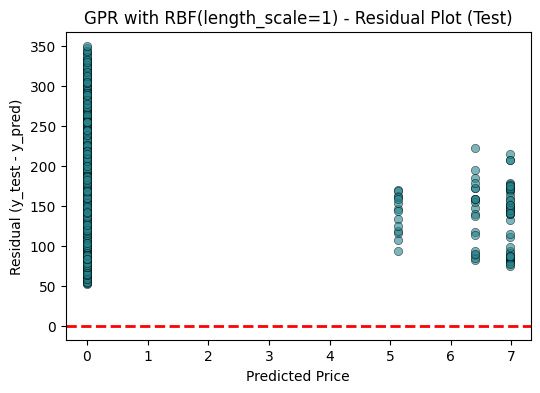

=== GPR with DotProduct(sigma_0=1) ===
Train -> R2: 0.168, MSE: 1663.18, RMSE: 40.78, MAE: 31.45
Test  -> R2: -0.920,  MSE: 4416.70,  RMSE: 66.46,  MAE: 52.97


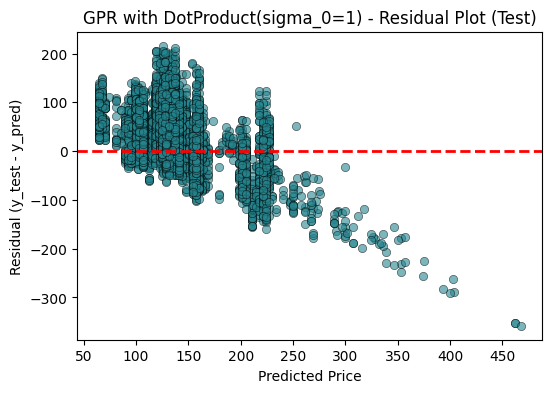

In [22]:
subset_size = 100  # למשל 100 דוגמאות
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

for kernel in [RBF(length_scale=1.0), DotProduct()]:
    try:
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            optimizer=None,       # ביטול האופטימיזציה
            alpha=1e-6,           # להבטיח יציבות במספרים
        )
        model_name = f"GPR with {kernel}"
        gpr = train_and_evaluate_model(gpr, X_train_sub, y_train_sub, X_test, y_test, model_name)
    except Exception as e:
        print(f"Error with kernel {kernel}: {e}")

### Gaussian Process Regression – Conclusions (Kayak)

Two kernel types were tested on a reduced training set (n=100):

#### 1. RBF Kernel (length_scale=1)
- **Train R²**: 0.662 – Model fits well on the small train set.
- **Test R²**: -12.919 – Severe overfitting, generalization failed.
- **Test RMSE**: 178.96, **MAE**: 172.39 – Huge prediction errors.
- **Observation**: The model fails completely on unseen data, likely due to the small sample size and the complexity of RBF on this data structure.

#### 2. DotProduct Kernel
- **Train R²**: 0.168 – Poor fit even on the training subset.
- **Test R²**: -0.920 – Model performs worse than a constant mean predictor.
- **Test RMSE**: 66.46, **MAE**: 52.97 – High prediction error.
- **Observation**: DotProduct also fails to capture useful trends in the data, both train and test performance are weak.

---

### Summary
- Both kernels performed **poorly** on the test data.
- The **RBF kernel severely overfitted**, while **DotProduct underfit** the data entirely.
- **GPR is not suitable for this dataset at this scale**, unless more data or careful kernel tuning is applied.